In [8]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
import seaborn as sns
from model import loss
from model import reverse_se3_diffusion
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from data import all_atom
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from openfold.np import residue_constants
from scipy.spatial.transform import Rotation
from analysis import metrics
from tmtools import tm_align
from openfold.data import data_transforms

import mdtraj as md
from openfold.np.relax import amber_minimize

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [9]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(au)
importlib.reload(all_atom)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(reverse_se3_diffusion)
importlib.reload(inference_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [10]:
# Load model
inference_conf_path = '../config/inference.yaml'
inference_conf = OmegaConf.load(inference_conf_path)

inference_conf.ckpt_dir = '../pkl_jar/ckpt/black_hole_0/15D_09M_2022Y_21h_23m_56s'

inference_conf.default_conf_path = '../config/base.yaml'

inference_conf.output_dir = '../results'
# print(OmegaConf.to_yaml(inference_conf))



# Old models will need manual setting of the config
conf_overrides = None
# conf_overrides = OmegaConf.create(
#     {
#         "model":{
#             "embed_aatype": True
#         },
#         'diffuser': {
#             "trans_schedule": 'exponential',
#             'trans_max_b': 20.0,
#             'rot_schedule': 'linear'
#         }
#     }
# )



# Set up sampler
sampler = inference_se3_diffusion.Sampler(
    inference_conf,
    use_ckpt_conf=True,
    conf_overrides=conf_overrides
)
train_loader, valid_loader = sampler.exp.create_rosetta_dataset(0, 1)
train_csv = train_loader.dataset.csv

INFO: Loading checkpoint from ../pkl_jar/ckpt/black_hole_0/15D_09M_2022Y_21h_23m_56s/step_210000.pth
INFO: Saving results to ../results/15D_09M_2022Y_21h_23m_56s
INFO: Number of model parameters 3703648
INFO: Using cached IGSO3.
INFO: Checkpoints saved to: ./pkl_jar/ckpt/black_hole_0/15D_09M_2022Y_21h_23m_56s/black_hole_0/17D_09M_2022Y_07h_58m_20s
INFO: Evaluation saved to: ./results/black_hole_0/15D_09M_2022Y_21h_23m_56s/black_hole_0/17D_09M_2022Y_07h_58m_20s
INFO: Training: 1000 examples
INFO: Validation: 40 examples with lengths [ 60  90 113 134 156 177 198 218 239 260]


### Sample using data

In [11]:
# Sample an example

# data_iter = iter(train_loader)
# next_item = next(data_iter)

data_iter = iter(valid_loader)
next_item, _ = next(data_iter)
b_idx = 1

valid_feats = tree.map_structure(
    lambda x: x[:b_idx], next_item)

res_mask = valid_feats['res_mask']
valid_feats = tree.map_structure(
    lambda x: x[res_mask.bool()][None] if x.ndim > 1 else x, valid_feats)

In [12]:
# Rotate translations
if False:
    rot = torch.tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix()).double()
    rot_pos_fn = lambda x: torch.einsum('...i,ji->...j', x, rot) 

    trans = valid_feats['rigids_t'][..., 4:]
    rot_trans = rot_pos_fn(trans)
    valid_feats['rigids_t'][..., 4:] = rot_trans

In [13]:
to_device = lambda y: tree.map_structure(lambda x: x.to(sampler.device), y)
infer_out = sampler.exp.inference_fn(
    to_device(valid_feats),
    add_noise=True)

In [14]:
sampled_rigids = infer_out[0]
sampled_bb_prots = infer_out[1]
final_prot = du.move_to_np(sampled_bb_prots[-1])

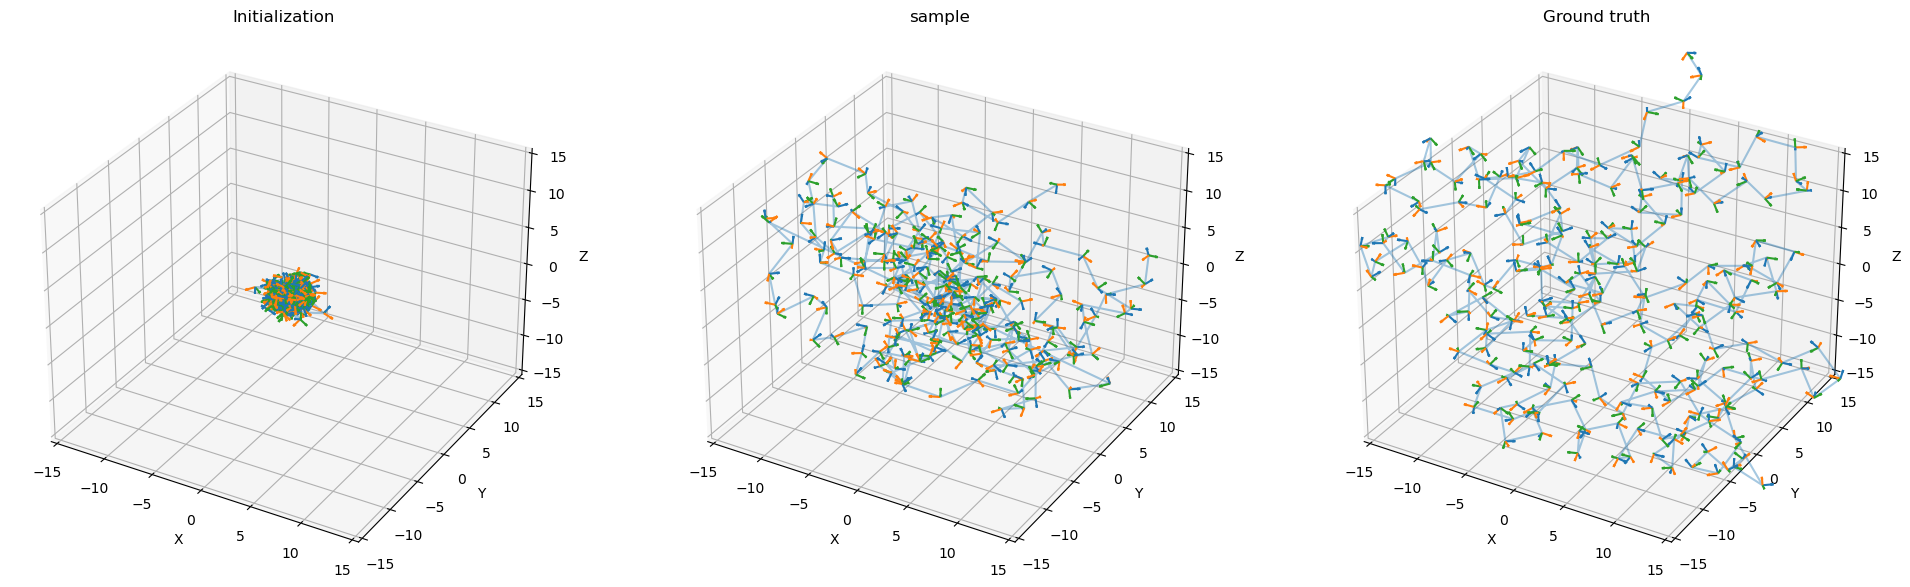

In [15]:
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = 1.0
ax_lim = 15.
res_mask = valid_feats['res_mask'][0]
plotting.viz_frames(valid_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(sampled_rigids[-1][0], res_mask, axes[1], title='sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(valid_feats['rigids_0'][0], res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [16]:
from tmtools import tm_align

In [44]:
valid_feats.keys()

dict_keys(['aatype', 'res_idx', 'res_mask', 'atom37_pos', 'atom37_mask', 'atom14_pos', 'atom14_mask', 'rigidgroups_0', 'rigidgroups_0_exists', 'torsion_angles_sin_cos', 'torsion_angles_mask', 'rigids_0', 'rigids_t', 'trans_score', 'rot_score', 't', 'rot_score_norm', 'trans_score_norm'])

In [35]:
aatype = du.move_to_np(valid_feats['aatype'][0]).tolist()
seq = ''.join([residue_constants.restypes[x] for x in aatype])
pos_1 = du.move_to_np(sampled_rigids[-1][0][:, 4:])
pos_2 = du.move_to_np(valid_feats['rigids_0'][0][:, 4:])

In [41]:
tm_results = tm_align(pos_2, pos_2, seq, seq)

In [42]:
tm_results.tm_norm_chain1

1.0

In [43]:
tm_results.tm_norm_chain2

1.0

In [16]:
# Run sampler
save = True
add_noise = True
batch_size = 1
res_mask = next_item['res_mask'][:batch_size]
aatype = next_item['aatype'][:batch_size]
res_idx = next_item['res_idx'][:batch_size]
samples_traj = sampler.sample(
    res_mask=res_mask,
    aatype=aatype,
    save=save,
    res_idx=res_idx,
    file_prefix='./samples/',
    add_noise=add_noise
)
rigid_samples, prot_samples = samples_traj

INFO: Saved sample to ./samples/len_218_1.pdb
INFO: Saved trajectory to ./samples/len_218_traj_1.pdb


In [ ]:
b_idx = 0
pred_prot = prot_samples[b_idx]

In [74]:
from Bio import PDB

In [76]:
parser = PDB.PDBParser(QUIET=True)

pdb_path = './samples/len_90_1.pdb'
pdb_name = 'test'
structure = parser.get_structure(pdb_name, pdb_path)

struct_chains = {
    chain.id: chain
    for chain in structure.get_chains() if chain.id == 'A'}
# TODO: Add logic for handling multiple chains.
assert len(struct_chains) == 1

chain_prot = du.process_chain(struct_chains['A'], 'A')

In [ ]:
chain_prot.atom_positions

In [86]:
traj = md.load(pdb_path)

# SS percentage
pdb_ss = md.compute_dssp(traj, simplified=True)
pdb_coil_percent = np.mean(pdb_ss == 'C')
pdb_helix_percent = np.mean(pdb_ss == 'H')
pdb_strand_percent = np.mean(pdb_ss == 'E')
pdb_ss_percent = pdb_helix_percent + pdb_strand_percent 

# Radius of gyration
pdb_rg = md.compute_rg(traj)[0]
# atom37_mask = np.any(atom37_pos, axis=-1)
# prot = au.create_full_prot(atom37_pos, atom37_mask)

violation_metrics = amber_minimize.get_violation_metrics(chain_prot)
struct_violations = violation_metrics['structural_violations']
inter_violations = struct_violations['between_residues']

# Geometry
bb_mask = np.any(chain_prot.atom_mask, axis=-1)
ca_pos = chain_prot.atom_positions[..., residue_constants.atom_order['CA'], :][bb_mask]
ca_ca_bond_dev, ca_ca_valid_percent = metrics.ca_ca_distance(ca_pos)
num_ca_steric_clashes, ca_steric_clash_percent = metrics.ca_ca_clashes(ca_pos) 

In [ ]:
struct_violations

In [89]:
ca_ca_valid_percent

0.5393258426966292

In [ ]:
ca_pos

In [97]:
ca_bond_dists = np.linalg.norm(
    ca_pos - np.roll(ca_pos, 1, axis=0), axis=-1)[1:]
# ca_ca_dev = np.mean(np.abs(ca_bond_dists - residue_constants.ca_ca))
# ca_ca_valid = np.mean(ca_bond_dists < (residue_constants.ca_ca + tol))

(array([ 1.,  2.,  4., 13., 14., 15., 22.,  9.,  5.,  4.]),
 array([3.16954357, 3.29310473, 3.41666589, 3.54022705, 3.66378822,
        3.78734938, 3.91091054, 4.03447171, 4.15803287, 4.28159403,
        4.40515519]),
 <BarContainer object of 10 artists>)

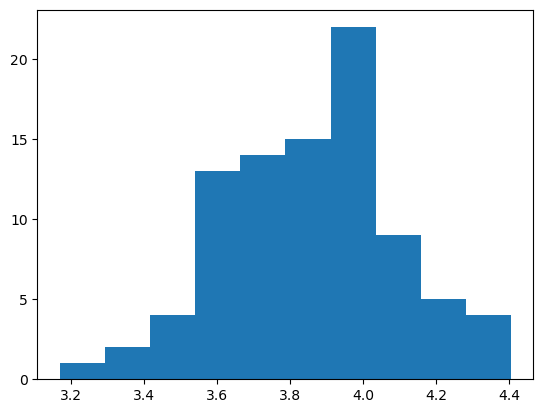

In [98]:
plt.hist(ca_bond_dists)

In [63]:
# Run sampler
batch_size = 4
num_res = 150
res_mask = torch.ones((batch_size, num_res))
save = True
samples_traj = sampler.sample(
    res_mask=res_mask,
    save=save,
    file_prefix='./samples/'
)

INFO: Saved sample to ./samples/len_150_1.pdb
INFO: Saved trajectory to ./samples/len_150_traj_1.pdb
INFO: Saved sample to ./samples/len_150_2.pdb
INFO: Saved trajectory to ./samples/len_150_traj_2.pdb
INFO: Saved sample to ./samples/len_150_3.pdb
INFO: Saved trajectory to ./samples/len_150_traj_3.pdb
INFO: Saved sample to ./samples/len_150_4.pdb
INFO: Saved trajectory to ./samples/len_150_traj_4.pdb
